<a href="https://colab.research.google.com/github/Kartikk9650/Machine-Learning/blob/main/Potato_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Pattern and Anomaly Detection/Dataset

/content/drive/MyDrive/Colab Notebooks/Pattern and Anomaly Detection/Dataset


In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json # to change permissions
!rm kaggle.json

In [ ]:
!kaggle datasets download -d arjuntejaswi/plant-village/

400 - Bad Request - Invalid datasetVersionNumber value


In [ ]:
!unzip plant-village.zip

Streaming output truncated to the last 5000 lines.
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-7476153023ce___YLCV_GCREC 2258.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Cur

In [ ]:
%cd PlantVillage
!rm -r Pepper__bell___Bacterial_spot
!rm -r Pepper__bell___healthy
!rm -r Potato___Early_blight
!rm -r Potato___Late_blight
!rm -r Potato___healthy
'''
!rm -r Tomato_Bacterial_spot
!rm -r Tomato_Early_blight
!rm -r Tomato_Late_blight
!rm -r Tomato_Leaf_Mold
!rm -r Tomato_Septoria_leaf_spot
!rm -r Tomato_Spider_mites_Two_spotted_spider_mite
!rm -r Tomato__Target_Spot
!rm -r Tomato__Tomato_YellowLeaf__Curl_Virus
!rm -r Tomato__Tomato_mosaic_virus
!rm -r Tomato_healthy
'''
%cd ..

/content/drive/MyDrive/Colab Notebooks/Pattern and Anomaly Detection/Dataset/PlantVillage
/content/drive/MyDrive/Colab Notebooks/Pattern and Anomaly Detection/Dataset


##Importing Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 5

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [ ]:
len(dataset)

501

length is 68 because we make batches of 32 so it means dataset has 67 batches each containing 32 images and one batch containing remaining images. So that's how it totally makes to 67*32 = 2144 + 8 = 2152 images

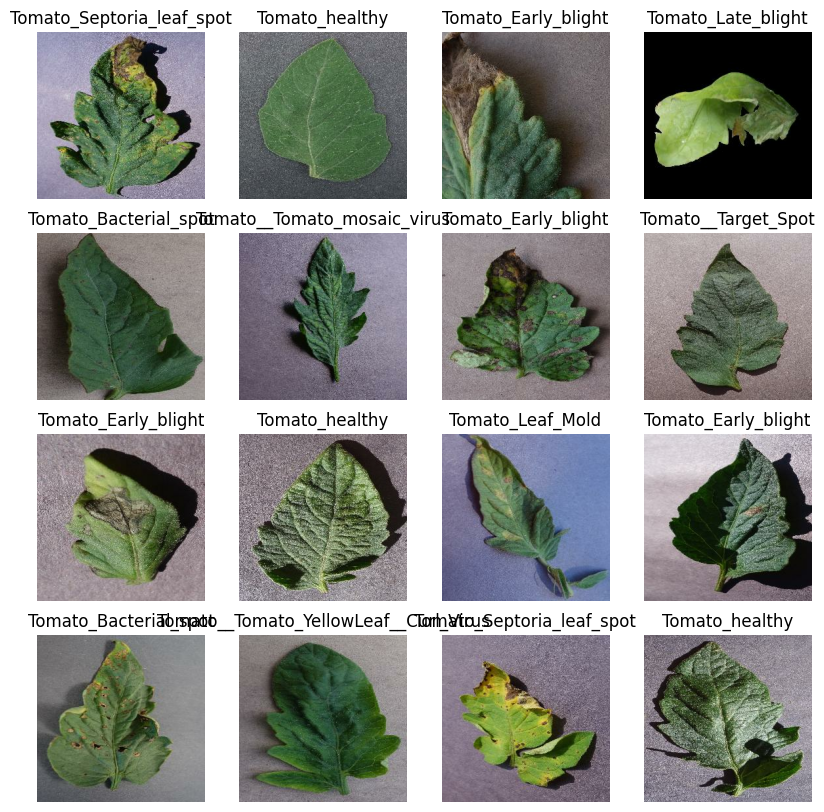

In [ ]:
# let's just try to visualize some images
plt.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1): #gives mentioned no. of batches
  for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

80% ==> training means 501 * 80% = 400 batches<br>20% ==> validation and testing (20% * 501 = 101 batches, means 50 batches for validation and 51 batches for testing)

We don't have train_test_split() in tensorflow.

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  ds_size = len(ds)

  if(shuffle):
    ds = ds.shuffle(shuffle_size, seed=12) # seed is just for predictability

  train_size = int(ds_size * train_split)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size + val_size)
  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
# cache() keeps an image into memory for reuse(next epoch) once we load image from disk it makes pipeline efficient and faster.
# prefetch() will load next batch by cpu while gpu is training on previous batch.
# buffer_size = tf.data.AUTOTUNE lets machine decide how many batches to prefetch while gpu training.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE,),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax') # softmax normalizes the probability of the classes.
])

model.build(input_shape = input_shape)

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1, # verbose defines how you want to 'see' the training progress for each epoch. 1 is for progress bar like ==================
    validation_data=val_ds
)

Epoch 1/5


In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 26ms/step - loss: 0.1051 - accuracy: 0.9688


In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

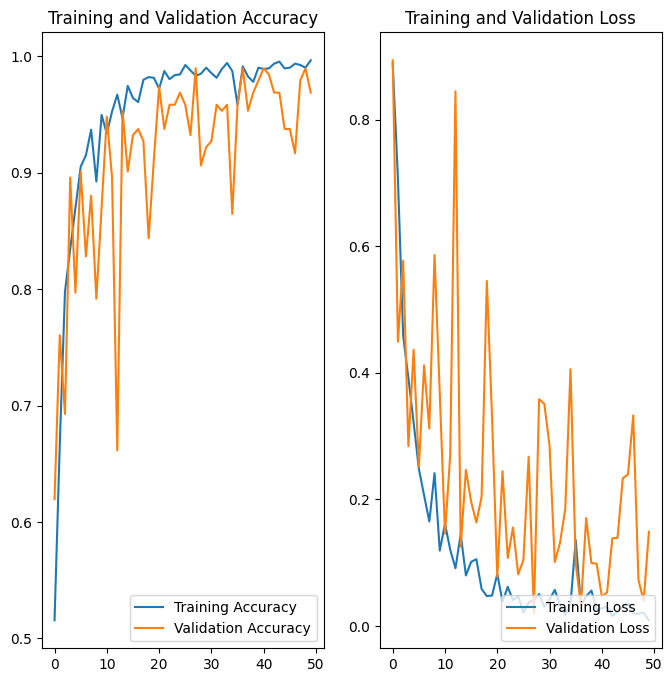

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

first image to predict
actual label: Potato___healthy
1/1 [==============================] - 0s 146ms/step
predicted label: Potato___healthy


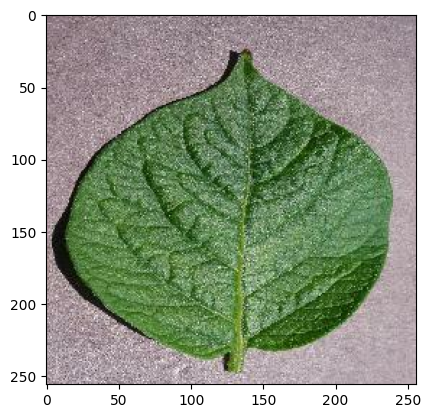

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/Colab Notebooks/Pattern and Anomaly Detection/Models") + [0]])+1
model.save(f"/content/drive/MyDrive/Colab Notebooks/Pattern and Anomaly Detection/Models/{model_version}")